In [2]:
import argparse
import os
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs('images', exist_ok = True)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [3]:
class Option():
    n_epochs = 200 # number of epochs of training
    batch_size = 64 # size of the batches
    lr = 0.00005 # learning rate
    n_cpu = 8 # number of cpu threads to use during batch generation
    latent_dim = 100 # dimensionality of the latent space
    n_critic = 5 # number of critics
    img_size = 28 # size of each image dimension
    channels = 1 # number of image channels
    clip_value = 0.01  # lower and upper clip value for disc. weights
    sample_interval = 500 # interval between image sampling

opt = Option()
cuda = True if torch.cuda.is_available() else False
img_shape = (opt.channels, opt.img_size, opt.img_size)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize = True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace = True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize = False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            # np.prod: 내부 값들의 곱
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        # *img_shape: 튜플이나 리스트의 요소를 개별적으로 전달
        img = img.view(img.shape[0], *img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [8]:
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


100%|██████████| 9912422/9912422 [00:00<00:00, 111537490.83it/s]


Extracting ../../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 65620635.87it/s]

Extracting ../../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29897119.60it/s]


Extracting ../../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16437039.49it/s]


Extracting ../../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/MNIST/raw



[Epoch 0/200] [Batch 0/938] [D loss: -0.017518] [G loss: 0.008037]


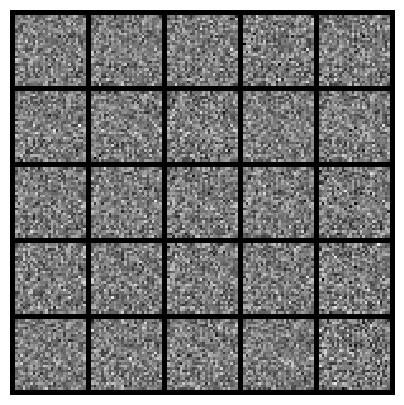

[Epoch 0/200] [Batch 500/938] [D loss: -2.429993] [G loss: -20.578316]


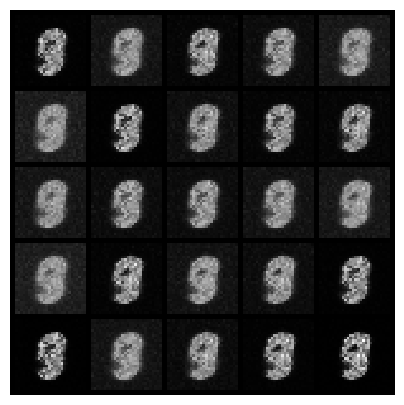

[Epoch 1/200] [Batch 62/938] [D loss: -0.446834] [G loss: -15.545197]


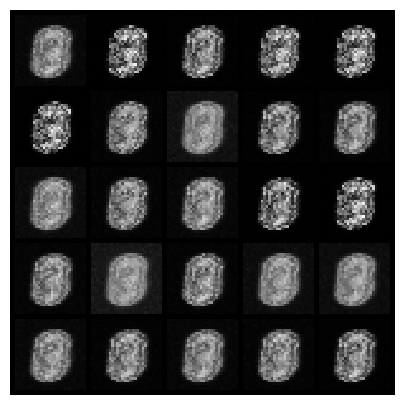

[Epoch 1/200] [Batch 562/938] [D loss: -0.120138] [G loss: -13.338940]


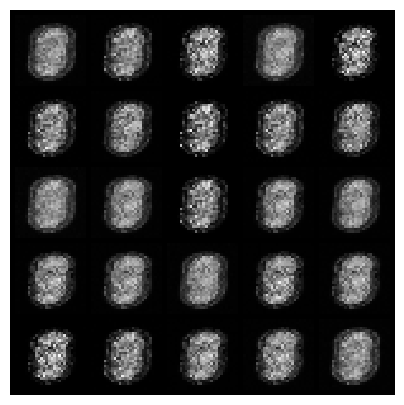

[Epoch 2/200] [Batch 124/938] [D loss: -0.125428] [G loss: -12.728427]


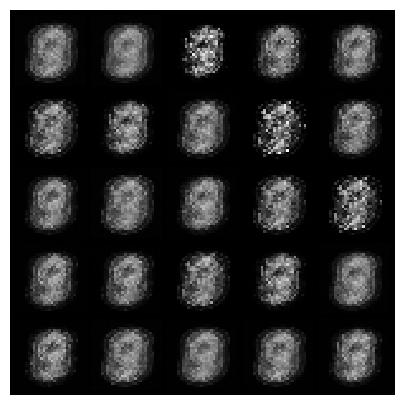

[Epoch 2/200] [Batch 624/938] [D loss: -0.014100] [G loss: -11.796209]


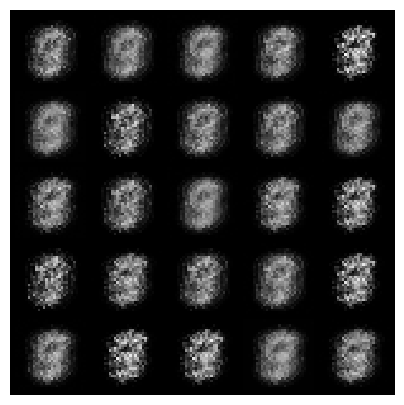

[Epoch 3/200] [Batch 186/938] [D loss: -0.040843] [G loss: -3.454216]


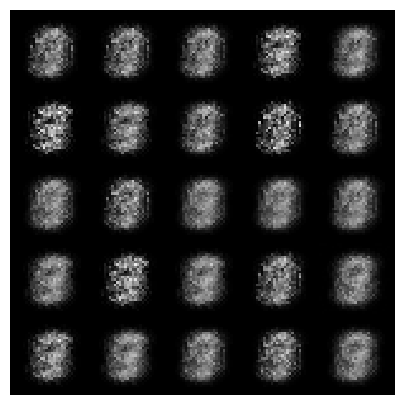

[Epoch 3/200] [Batch 686/938] [D loss: -0.115393] [G loss: -2.032116]


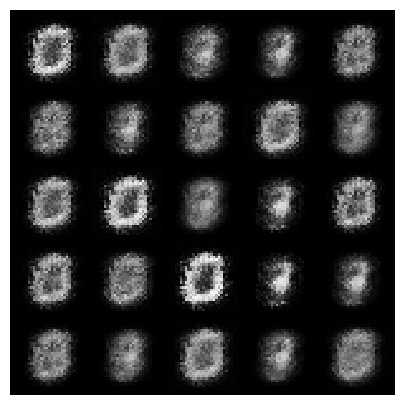

[Epoch 4/200] [Batch 248/938] [D loss: -0.469191] [G loss: -0.484189]


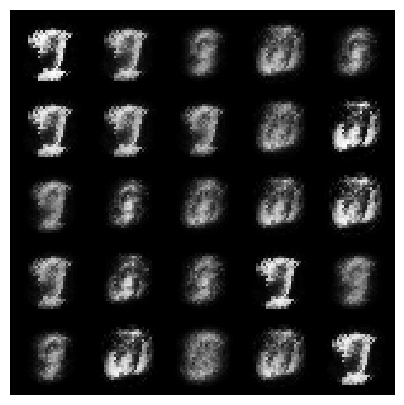

[Epoch 4/200] [Batch 748/938] [D loss: -0.180922] [G loss: -2.356105]


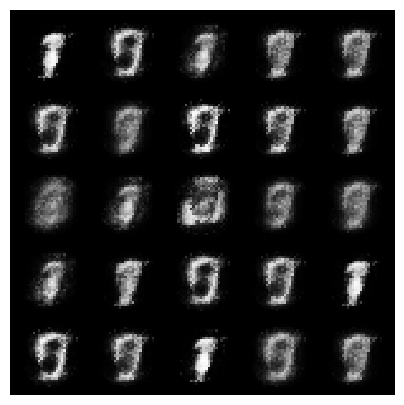

[Epoch 5/200] [Batch 310/938] [D loss: -0.559071] [G loss: -0.286193]


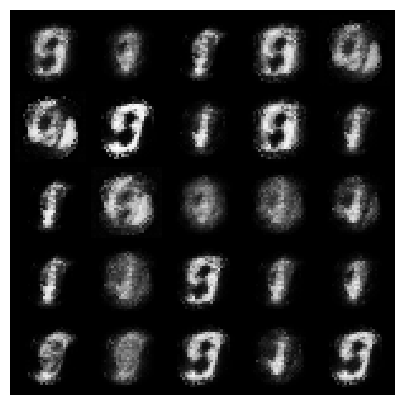

[Epoch 5/200] [Batch 810/938] [D loss: -0.149759] [G loss: -0.742800]


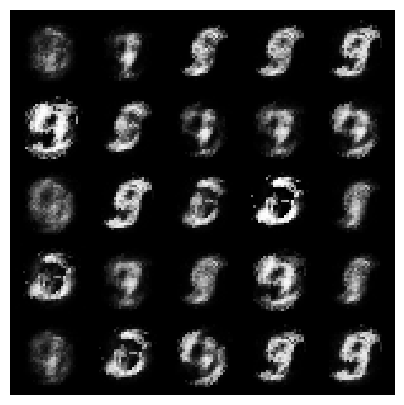

[Epoch 6/200] [Batch 372/938] [D loss: -0.413887] [G loss: -0.990884]


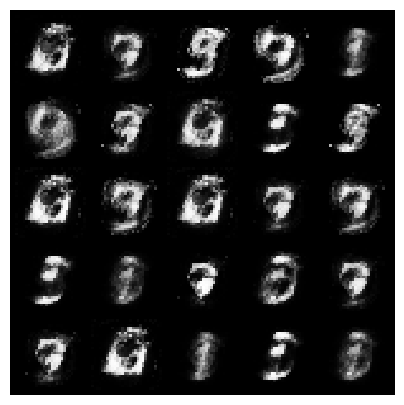

[Epoch 6/200] [Batch 872/938] [D loss: -0.703016] [G loss: -0.200730]


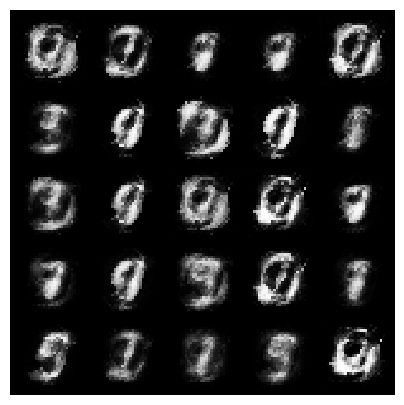

[Epoch 7/200] [Batch 434/938] [D loss: -0.354816] [G loss: -3.406610]


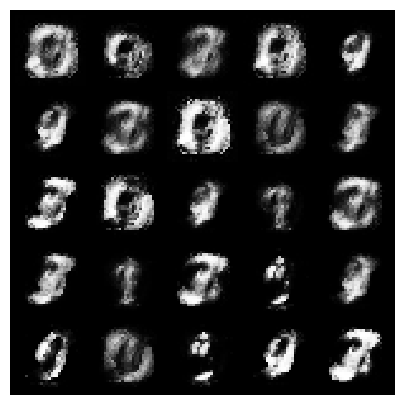

[Epoch 7/200] [Batch 934/938] [D loss: -0.540630] [G loss: -0.309801]


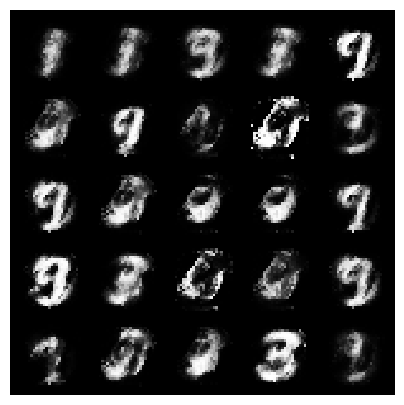

[Epoch 8/200] [Batch 496/938] [D loss: -0.824278] [G loss: -0.346423]


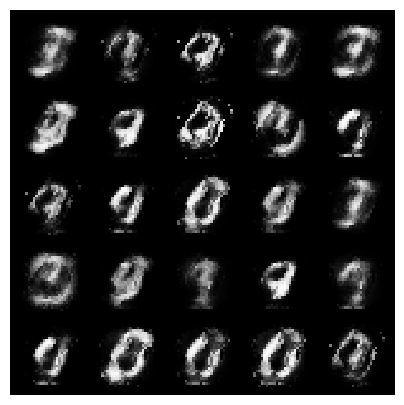

[Epoch 9/200] [Batch 58/938] [D loss: -0.529543] [G loss: -0.813909]


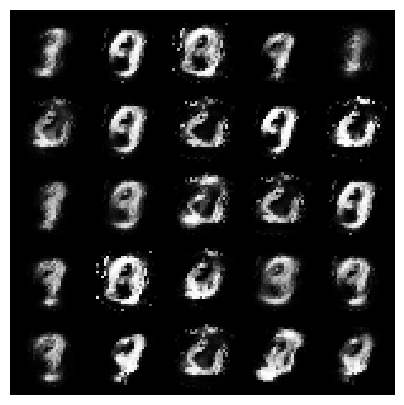

[Epoch 9/200] [Batch 558/938] [D loss: -0.468077] [G loss: -0.954397]


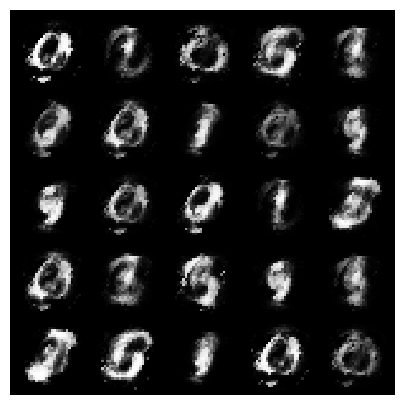

[Epoch 10/200] [Batch 120/938] [D loss: -0.654753] [G loss: -0.643833]


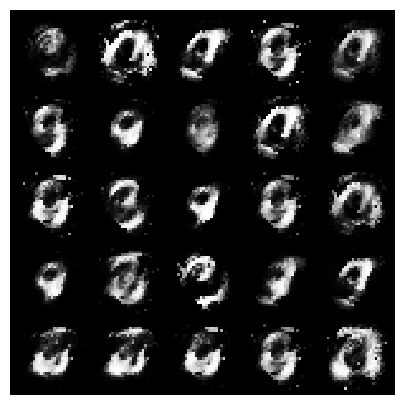

[Epoch 10/200] [Batch 620/938] [D loss: -0.462976] [G loss: -2.398086]


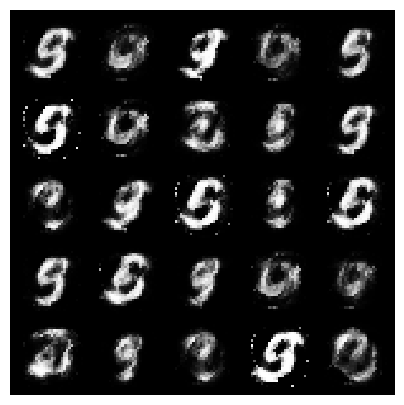

In [ ]:
batches_done = 0

for epoch in range(opt.n_epochs):

    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.type(Tensor).detach()

        optimizer_D.zero_grad()

        z = Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim)))

        fake_imgs = generator(z).detach()

        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()

        for p in discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)

        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
            )

            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

            plt.figure(figsize = (5,5))
            img1 = cv2.imread("images/%d.png" %batches_done)
            plt.imshow(img1, interpolation='nearest')
            plt.axis('off')
            plt.show()